In an [earlier post](http://johntfoster.github.io/posts/using-exoduspy-to-extract-data-from-fea-database.html) I demonstrated how to use a set of [ctypes](https://docs.python.org/2/library/ctypes.html) wrappers of Sandia's Exodus database format, i.e. the `exodus.py` script that is distributed with [Trilinos](http://trilinos.org), to extract information from an Exodus database format.  Exodus is a finite element format library that is build upon NetCDF4 and HDF5.  While the use of `exodus.py` makes for a straightforward and intuitive interface to the database, it requires that Trilinos (at least the SEACAS packages) be installed as a shared libraries with an `$ACCESS` environment variable in your `$PATH`.  This setup is cumbersome if you don't have any other reason to have Trilinos installed.  Thankfully, since Exodus files are NetCDF files are HDF files, we can use other tools to access the data.  One of those, that is mature and available in the [Python Package Index](https://pypi.python.org/pypi) is [netcdf4-python] https://github.com/Unidata/netcdf4-python.  It can easy be installed via `pip` i.e.

````
pip install netcdf4
````

or if your using the popular [Anaconda Python distribution](https://store.continuum.io/cshop/anaconda/) then

````
conda install netcdf4
````

should do the trick.  This is all we need to have installed to read from an Exodus database.  The simple 2D finite element mesh I will be using in the following example can be downloaded [here](files/s_curve.g)

First we'll import the module and of course Numpy.

In [1]:
import netCDF4
import numpy as np

To open the Exodus file for reading we use the following command.

In [2]:
nc = netCDF4.Dataset('s_curve.g')

Here we are using a "Genesis" file which is a Exodus file used for finite element model *input*.  It typically contains information about the nodal coordinates, mesh connectivity, nodesets for boundary condition application, etc.  A common source of creation for these forms of Exodus files is the mesh generation tool [Cubit](https://cubit.sandia.gov/).  We could access the *output* variant of an Exodus file (i.e. a `*.e` file) in the same manner.

Unless you take a lot of time carefully naming all your variables, nodesets, blocks, etc. during the creation of the database, the variables will be given default names with we can use to access that data.  The default names can are intuitive to with a little investigation of thier properties, you can usually figure out what they refer to.  To see all of the information of the database we can simply

In [3]:
print nc

<type 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_64BIT data model, file format NETCDF3):
    api_version: 4.98
    version: 4.98
    floating_point_word_size: 8
    file_size: 1
    title: cubit(/Users/john/Desktop/s_curve.g): 07/20/2015: 14:53:37
    dimensions(sizes): len_string(33), len_line(81), four(4), time_step(0), num_dim(3), num_nodes(468), num_elem(437), num_el_blk(1), num_qa_rec(1), num_node_sets(5), num_nod_ns1(21), num_nod_ns2(15), num_nod_ns3(17), num_nod_ns4(15), num_nod_ns5(17), num_el_in_blk1(437), num_nod_per_el1(4), num_att_in_blk1(1)
    variables(dimensions): float64 time_whole(time_step), |S1 qa_records(num_qa_rec,four,len_string), |S1 coor_names(num_dim,len_string), |S1 eb_names(num_el_blk,len_string), int32 ns_status(num_node_sets), int32 ns_prop1(num_node_sets), |S1 ns_names(num_node_sets,len_string), int32 node_ns1(num_nod_ns1), float64 dist_fact_ns1(num_nod_ns1), int32 node_ns2(num_nod_ns2), float64 dist_fact_ns2(num_nod_ns2), int32 node_ns3(num_nod_ns3)

Or to get more information about the variables

In [4]:
nc.variables

OrderedDict([(u'time_whole', <type 'netCDF4._netCDF4.Variable'>
float64 time_whole(time_step)
unlimited dimensions: time_step
current shape = (0,)
filling off
), (u'qa_records', <type 'netCDF4._netCDF4.Variable'>
|S1 qa_records(num_qa_rec, four, len_string)
unlimited dimensions: 
current shape = (1, 4, 33)
filling off
), (u'coor_names', <type 'netCDF4._netCDF4.Variable'>
|S1 coor_names(num_dim, len_string)
unlimited dimensions: 
current shape = (3, 33)
filling off
), (u'eb_names', <type 'netCDF4._netCDF4.Variable'>
|S1 eb_names(num_el_blk, len_string)
unlimited dimensions: 
current shape = (1, 33)
filling off
), (u'ns_status', <type 'netCDF4._netCDF4.Variable'>
int32 ns_status(num_node_sets)
unlimited dimensions: 
current shape = (5,)
filling off
), (u'ns_prop1', <type 'netCDF4._netCDF4.Variable'>
int32 ns_prop1(num_node_sets)
    name: ID
unlimited dimensions: 
current shape = (5,)
filling off
), (u'ns_names', <type 'netCDF4._netCDF4.Variable'>
|S1 ns_names(num_node_sets, len_string)


I won't attempt to decipher all the information in the database as you can use the [Exodus API reference](http://prod.sandia.gov/techlib/access-control.cgi/1992/922137.pdf) for that.  Below, I'll show a short example of how we might do something useful.  First we will, extract the `X` and `Y` nodal coordinate locations from and the connectivity array.  The first 10 entries of the connectivity array are shown.

In [5]:
X = nc.variables['coordx']
Y = nc.variables['coordy']
connect = nc.variables['connect1']
print connect[0:10]

[[ 1  2  3  4]
 [ 2  5  6  3]
 [ 5  7  8  6]
 [ 7  9 10  8]
 [ 9 11 12 10]
 [11 13 14 12]
 [13 15 16 14]
 [15 17 18 16]
 [17 19 20 18]
 [19 21 22 20]]


Now we'll use the nodal locations and the connectivity array to plot a visualization of the mesh.  First, we upload the required libraries from matplotlib.

In [6]:
%matplotlib inline
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import matplotlib.pyplot as plt
import matplotlib

Now we'll create an array that contains the $x,y$ nodal coordinate location pairs and extract, via Numpy fancy indexing, the coordinates for each quadralateral in the mesh, creating polygons with them for visualization.

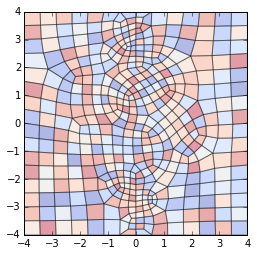

In [7]:
xy = np.array([X[:], Y[:]]).T

patches = []
for coords in xy[connect[:]-1]:
    quad = Polygon(coords, True)
    patches.append(quad)

fig, ax = plt.subplots()
colors = 100 * np.random.rand(len(patches))
p = PatchCollection(patches, cmap=matplotlib.cm.coolwarm, alpha=0.4)
p.set_array(np.array(colors))
ax.add_collection(p)
ax.set_xlim([-4, 4])
ax.set_ylim([-4, 4])
#plt.colorbar(p)
ax.set_aspect('equal')
plt.show()

The colors have no meaning other than to give each element a random color.  Now we'll close the Exodus file, completing our analysis.

In [8]:
nc.close()